![](https://i.imgur.com/OjgBHDk.png)

In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

netflix = pd.read_csv("netflix_titles.csv")
netflix = netflix.sort_values(by='title', ascending=True)
netflix.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s2037,Movie,#Alive,Cho Il,"Yoo Ah-in, Park Shin-hye",South Korea,"September 8, 2020",2020,TV-MA,99 min,"Horror Movies, International Movies, Thrillers","As a grisly virus rampages a city, a lone man ..."
1,s2305,Movie,#AnneFrank - Parallel Stories,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",Italy,"July 1, 2020",2019,TV-14,95 min,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol..."
2,s2482,Movie,#FriendButMarried,Rako Prijanto,"Adipati Dolken, Vanesha Prescilla, Rendi Jhon,...",Indonesia,"May 21, 2020",2018,TV-G,102 min,"Dramas, International Movies, Romantic Movies","Pining for his high school crush for years, a ..."
3,s2325,Movie,#FriendButMarried 2,Rako Prijanto,"Adipati Dolken, Mawar de Jongh, Sari Nila, Von...",Indonesia,"June 28, 2020",2020,TV-G,104 min,"Dramas, International Movies, Romantic Movies",As Ayu and Ditto finally transition from best ...
4,s5974,Movie,#Roxy,Michael Kennedy,"Jake Short, Sarah Fisher, Booboo Stewart, Dann...",Canada,"April 10, 2019",2018,TV-14,105 min,"Comedies, Romantic Movies",A teenage hacker with a huge nose helps a cool...
5,s5696,Movie,#Rucker50,Robert McCullough Jr.,NaN,United States,"December 1, 2016",2016,TV-PG,56 min,"Documentaries, Sports Movies",This documentary celebrates the 50th anniversa...
6,s655,Movie,#Selfie,Cristina Jacob,"Flavia Hojda, Crina Semciuc, Olimpia Melinte, ...",Romania,"June 21, 2021",2014,TV-MA,125 min,"Comedies, Dramas, International Movies","Two days before their final exams, three teen ..."
7,s656,Movie,#Selfie 69,Cristina Jacob,"Maia Morgenstern, Olimpia Melinte, Crina Semci...",Romania,"June 21, 2021",2016,TV-MA,119 min,"Comedies, Dramas, International Movies","After a painful breakup, a trio of party-lovin..."
8,s2667,TV Show,#blackAF,NaN,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,"April 17, 2020",2020,TV-MA,1 Season,TV Comedies,Kenya Barris and his family navigate relations...
9,s5973,Movie,#cats_the_mewvie,Michael Margolis,NaN,Canada,"February 5, 2020",2020,TV-14,90 min,"Documentaries, International Movies",This pawesome documentary explores how our fel...


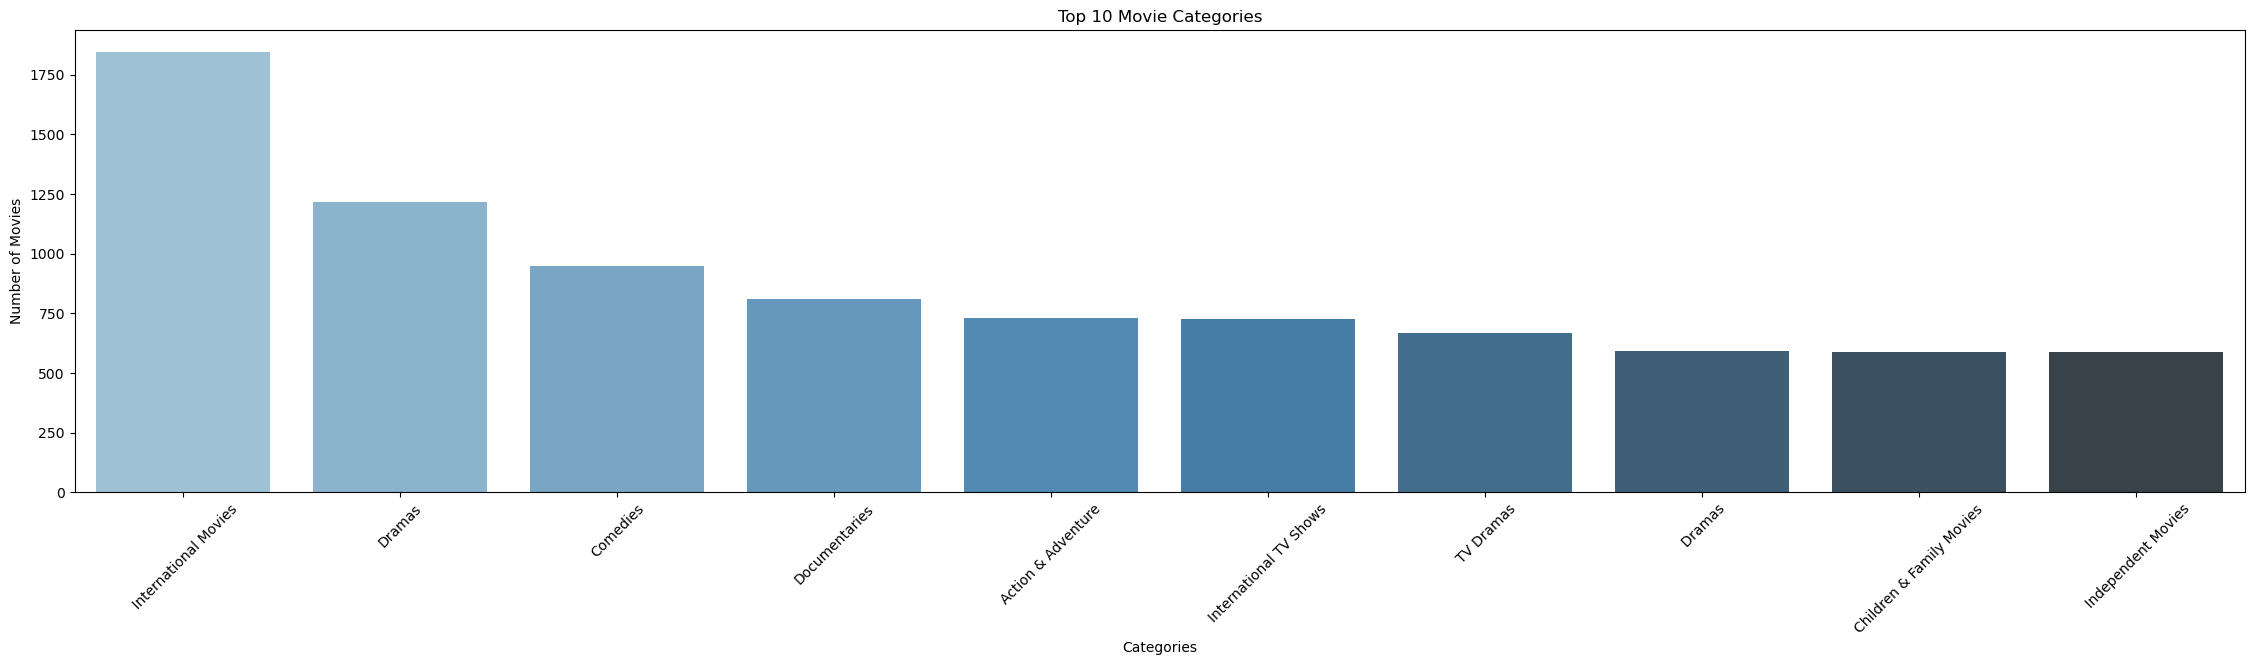

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

categories = netflix['listed_in'].str.split(',', expand=True).stack().value_counts()

# Let's take the top 10 categories for visualization
top_categories = categories[:10]

plt.figure(figsize=(28,6))
sns.barplot(x=top_categories.index, y=top_categories.values, palette="Blues_d")
plt.title('Top 10 Movie Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


In [31]:
def prepare_data(max_features=10):
    df_cosine = pd.read_csv("netflix_titles.csv")
    df_cosine["description"] = df_cosine["description"].fillna("")
    tfidf = TfidfVectorizer(stop_words="english", max_features=max_features, ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(df_cosine["description"])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    indices = pd.Series(df_cosine.index, index=df_cosine["title"]).drop_duplicates()
    filledna = df_cosine.fillna("")
    features = ["title", "director", "cast", "listed_in", "description"]
    for feature in features:
        filledna[feature] = filledna[feature].apply(lambda x: str.lower(x.replace(" ", "")))
    filledna["soup"] = filledna.apply(lambda x: " ".join(x[feature] for feature in features), axis=1)
    count = CountVectorizer(stop_words="english")
    count_matrix = count.fit_transform(filledna["soup"])
    cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
    filledna = filledna.reset_index()
    indices = pd.Series(filledna.index, index=filledna["title"])
    return df_cosine, indices, cosine_sim, cosine_sim2

def get_recommendations(title, df_cosine, indices, cosine_sim, num_recommendations=5):
    title = title.replace(" ", "").lower()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    df_scores = pd.DataFrame(sim_scores, columns=['Index', 'Score'])
    df_scores['Index'] = df_scores['Index'].apply(lambda i: df_cosine['title'].iloc[i])
    df_scores.set_index('Index', inplace=True)
    plt.figure(figsize=(12,8))
    sns.heatmap(df_scores, annot=True, cmap='coolwarm')
    plt.title('Similarity Scores')
    plt.show()
    return df_cosine["title"].iloc[movie_indices]

In [32]:
import ipywidgets as widgets
from IPython.display import display

# Assuming 'title' is the column in the 'netflix' dataframe that contains the movie names
# Assuming 'release_year' is the column in the 'netflix' dataframe that contains the release years
year_list = ['All Years'] + sorted(netflix['release_year'].unique().tolist())

dropdown_movie = widgets.Dropdown(
    description = 'Movies:',
    disabled = False,
)

dropdown_year = widgets.Dropdown(
    options = year_list,
    description = 'Year:',
    disabled = False,
)

def update_movies(*args):
    selected_year = dropdown_year.value
    if selected_year == 'All Years':
        # If 'All Years' is selected, show all movies
        filtered_movies = netflix['title'].unique().tolist()
    else:
        # Filter the movies based on the selected year
        filtered_movies = netflix[netflix['release_year'] == selected_year]['title'].unique().tolist()
    dropdown_movie.options = filtered_movies

def on_change_movie(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global selected_movie
        selected_movie = change['new']
        print(f"Selected Movie: {selected_movie}")

dropdown_year.observe(update_movies, 'value')
dropdown_movie.observe(on_change_movie, 'value')

display(dropdown_year, dropdown_movie)


Dropdown(description='Year:', options=('All Years', 1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956…

Dropdown(description='Movies:', options=(), value=None)

Selected Movie: Dawson's Creek
Selected Movie: Men in Black II


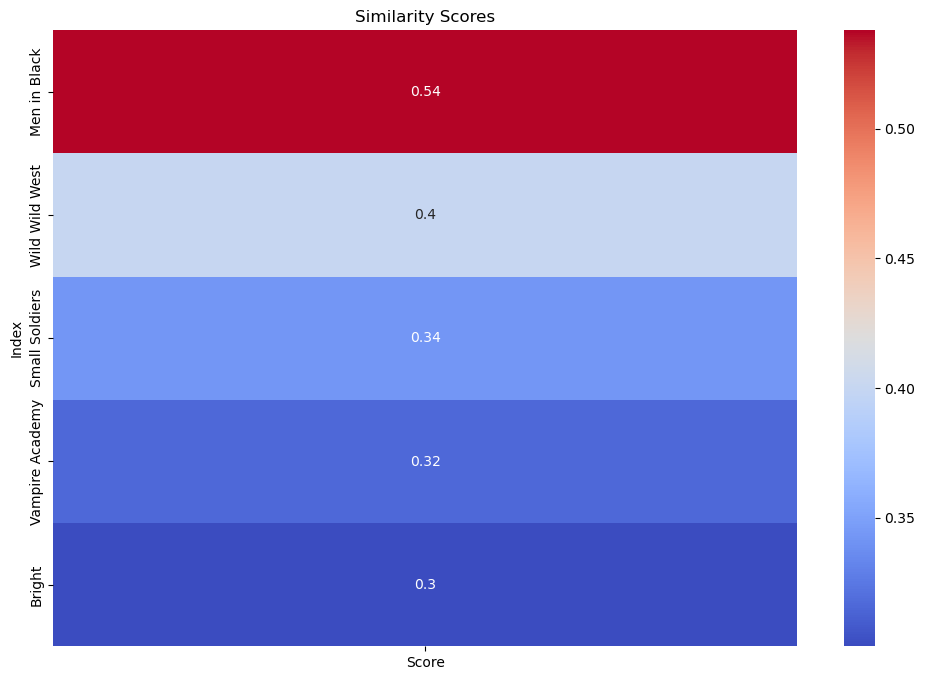

3966       Men in Black
7658     Wild Wild West
5588     Small Soldiers
7419    Vampire Academy
1076             Bright
Name: title, dtype: object

In [33]:
# Now you can change max_features and see its effect on the output
df_cosine, indices, cosine_sim, cosine_sim2 = prepare_data(max_features=5000000)
get_recommendations(selected_movie, df_cosine, indices, cosine_sim2, num_recommendations=5)